# Fruit Classification<a class="tocSkip">
&copy; 2021 by Michael Stanley (Mike.Stanley@ieee.org)<BR>
Last revised: 28 May 2021
    
This notebook demonstrates the use of a number of Scikit Learn classification algorithms.  Data was generated using the RGB sensor functionality on the Arduino Nano 33 BLE Sense board.  The RGB LED on that board was programmed to generate white light to illuminate a surface.  Then the APDS-9960 sensor converted the reflected light into Clear, Red, Green and Blue components which were then streamed to a laptop. 
    
For this test, we use the sensor to differentiate between pictures of bananas, oranges, red and green apples.
That data was recorded in:
* bananas.csv
* Oranges.csv
* RedApples.csv
* GreenApples.csv

all of which are required by this script.  
    
There are 6 columns in the recorded files.  From left to right:
<ol>
<li>sample number assigned by the laptop-based data logger program
<li>Red component (R)
<li>Green component (G)
<li>Blue component (B)
<li>Clear component (C)
<li>sample number assigned by the Arduino
</ol>
    
(1) and (6) will not match in general, as (6) is assigned from board power up and may also have gaps for times when the data logging process was paused.  They are not needed for the analysis and are dropped early in the processing.
    
![Misc. Fruits](../images/Fruit/fruits.png)    
    
This notebook uses micromlgen, sklearn-porter and emlearn libraries.  They can be used to export a variety of trained models straight into C code that can be embedded on a microcontroller.
    
You can install these libraries using the pip commands in the following cells.  Just uncomment a cell, execute it once, then recomment.  You only have to run them once to update your python environment.

In [1]:
#pip install micromlgen

In [2]:
#pip install sklearn-porter

In [3]:
#pip install emlearn

# Import standard Models
The next cell imports functions from a variety of Python modules.  These are all well-documented on the web, and a quick Google search will yield details on each.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture, svm, metrics
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from micromlgen import port
from sklearn_porter import Porter
import emlearn

C:\SPB_Data\.conda\envs\sensmach\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\SPB_Data\.conda\envs\sensmach\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.weight_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\SPB_Data\.conda\envs\sensmach\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and

In [5]:
# set default font for charts
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

# Read CSV files
* Read input CSV files into Pandas dataframes
* Assign class values to each new dataframe as it is created (each input file corresponds to data for one class)
* Merge those into one data frame
* Drop the sample number columns
* shuffle the records and then break that data into separate features and results dataFrames.  
* Then display the first few lines of the shuffled dataset.

In [6]:
classNames = ['Bananas', 'Oranges','RedApples','GreenApples']
fn = 'FruitFiles/bananas.csv'
banana_data = pd.read_csv(fn, names=['I', 'R', 'G', 'B', 'C', 'SampleNum'])
banana_data['Class']=0

fn = 'FruitFiles/oranges.csv'
orange_data = pd.read_csv(fn, names=['I', 'R', 'G', 'B', 'C', 'SampleNum'])
orange_data['Class']=1

fn = 'FruitFiles/RedApples.csv'
red_apple_data = pd.read_csv(fn, names=['I', 'R', 'G', 'B', 'C', 'SampleNum'])
red_apple_data['Class']=2

fn = 'FruitFiles/GreenApples.csv'
green_apple_data = pd.read_csv(fn, names=['I', 'R', 'G', 'B', 'C', 'SampleNum'])
green_apple_data['Class']=3

frames = [banana_data, orange_data, red_apple_data, green_apple_data]
data = pd.concat(frames)

# The 'I' and 'SampleNum' columns represent the sample number from the perspective of the data logger and embedded
# code respectively.  They are in place primarily as a visual check of the data stream accuracy, and are
# not needed for the machine learning task.  So drop them.
data = data.drop(['I', 'SampleNum'], axis=1)
print('Data shape retreived from the features data file is: ', str(data.shape))

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

display(data)

Data shape retreived from the features data file is:  (452, 5)


,R,G,B,C,Class
0,38,13,18,62,2
1,44,31,23,92,0
2,37,18,13,64,1
3,60,28,23,106,1
4,14,12,7,32,3
...,...,...,...,...,...
447,33,18,11,59,0
448,33,16,12,55,1
449,49,43,30,117,3
450,25,7,9,38,2


# Normalize RGB values by C
Since conceptully, the C channel should react to each of R, G & B components, it can be viewed as the overall light
intensity.  To make the classifier more robust, we'll normalize RGB components by C so that they reflect a relative percentage of the light, rather than absolute intensity of each channel.  Note that C is not precisely = R+G+B, but it's close enough to provide a pretty good approximation.

<b>WARNING!</b> We're doing this normalization "in place", meaning that the original features dataframe is reused.  Cells must be run in the order shown or you'll get strange results.

In [7]:
features = data
features['Rnorm']=features['R'].divide(features['C'])
features['Gnorm']=features['G'].divide(features['C'])
features['Bnorm']=features['B'].divide(features['C'])
features=features.drop(['R', 'G', 'B', 'C'], axis=1)
features.to_csv('FruitFiles/features.csv', index=False)
features.head()

,Class,Rnorm,Gnorm,Bnorm
0,2,0.612903,0.209677,0.290323
1,0,0.478261,0.336957,0.250000
2,1,0.578125,0.281250,0.203125
3,1,0.566038,0.264151,0.216981
4,3,0.437500,0.375000,0.218750


# Check to see if the data set is balanced
You want your training set to be balanced, that is have the same number of samples for each class.  Otherwise you run the risk of having a biased model.  If unbalanced, you can:
* collect more samples
* resample your database (see https://elitedatascience.com/imbalanced-classes and https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)

In [8]:
counts = features['Class'].value_counts()

for i in range(4):
    print(classNames[i], '\t: ', counts[i])

Bananas 	:  112
Oranges 	:  112
RedApples 	:  115
GreenApples 	:  113


# Split features and class membership into separate tables.

In [9]:
results=features['Class'].astype(int)
features = features.drop(['Class'], axis=1)
print('Features:')
display(features.head())
print('Results:')
display(results.head())
# List out the unique class assignments as a check (should be 0 through 3).
results.unique()

Features:


,Rnorm,Gnorm,Bnorm
0,0.612903,0.209677,0.290323
1,0.478261,0.336957,0.250000
2,0.578125,0.281250,0.203125
3,0.566038,0.264151,0.216981
4,0.437500,0.375000,0.218750


Results:


0    2
1    0
2    1
3    1
4    3
Name: Class, dtype: int32

array([2, 0, 1, 3], dtype=int64)

# Split data into training and test sets
You should always separate your data into separate training and validation sub-sets.

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(features.to_numpy(), results.to_numpy(), test_size=0.33, random_state=37)


# Subroutine for XY plots: myScatter()
This utility function can create an XY plot of two features found in the input table.  We use it here to look at 2D slices of our 3D data.

This particular function works with numpy arrays only.

Normalized input data


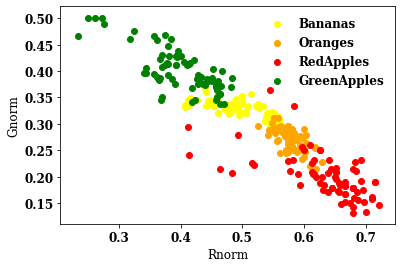

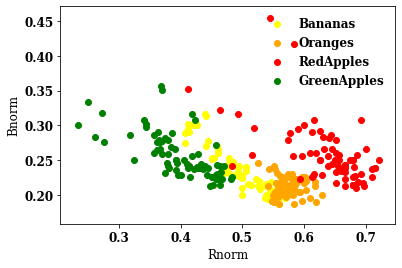

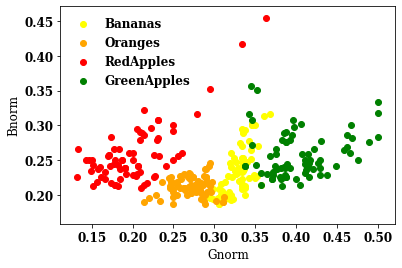

In [11]:
def myScatter(featureNames, X, idx0, idx1, Y):
    labels=['Off', 'Low', 'Medium', 'High']
    color = ['yellow', 'orange', 'red', 'green']
    fig, ax = plt.subplots()
    x0 = X[:,idx0]
    x1 = X[:,idx1]
    for g in np.unique(Y):
        ix = np.where(g==Y)
        c=color[g]
        ax.scatter(x0[ix], x1[ix], c=c, label=labels[g])
    plt.legend(loc='best', frameon=False, labels=['Bananas', 'Oranges', 'RedApples', 'GreenApples'])
    plt.xlabel(featureNames[idx0])
    plt.ylabel(featureNames[idx1])

print('Normalized input data')
myScatter(features.columns, X_train, 0, 1, Y_train)
myScatter(features.columns, X_train, 0, 2, Y_train)
myScatter(features.columns, X_train, 1, 2, Y_train)


# Train a model
We've included three classifier options here: multilayer perceptron, AdaBoost Classifier which uses max 2-deep decision
trees as base estimators, and LogisticRegression.  Choose mt=1, 2 or 3 to select which one you want to run.

In [12]:
mt = 4

if mt==1:
    model = MLPClassifier(hidden_layer_sizes=(12,), max_iter=1000, alpha=1e-4,
                        solver='sgd', verbose=10, random_state=1,
                        learning_rate_init=.1, batch_size=10, shuffle=True)
elif mt==2:
    model=LogisticRegression(C=1)   
    
elif mt==3:
    n_estimators=10
    model=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), 
                             algorithm="SAMME.R", n_estimators=n_estimators, random_state=777)
    
elif mt==4:
    model=DecisionTreeClassifier(random_state=0)
    
elif mt==5:
    model=RandomForestClassifier(max_depth=3, random_state=0)

elif mt==6:
    model=svm.SVC(kernel='linear', gamma=.25)

elif mt==7:
    model=GaussianNB()


clf=model.fit(X_train, Y_train)

print("Training set score: %f" % model.score(X_train, Y_train))
print("Test set score: %f" % model.score(X_test, Y_test))

Training set score: 1.000000
Test set score: 0.920000


# Now look at the confusion matrices
## Training Confusion Matrix

Confusion matrix for the training set


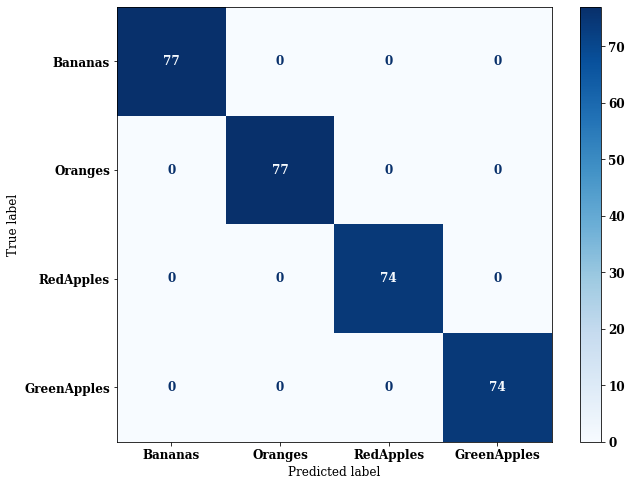

In [13]:

fig, ax = plt.subplots(1, 1, figsize=(10,8))
print('Confusion matrix for the training set')
cm1=metrics.plot_confusion_matrix(model, X_train, Y_train, ax=ax, display_labels=classNames, cmap=plt.cm.Blues, values_format='n')

## Test Confusion Matrix

Confusion matrix for the test set


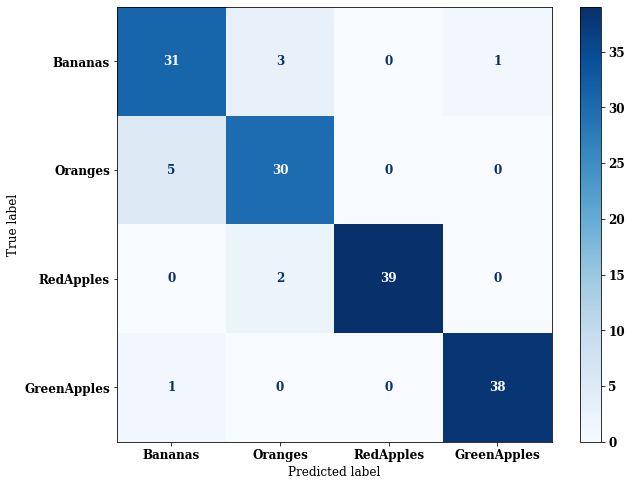

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
print('Confusion matrix for the test set')
cm2=metrics.plot_confusion_matrix(model, X_test, Y_test, ax=ax, display_labels=classNames, cmap=plt.cm.Blues, values_format='n')

# Convert model to "C" if possible
## Using the MicroML converter
Reference: https://github.com/eloquentarduino/micromlgen

The MicroML converter supports (among others):
* Decision Tree
* Random Forest
* Support Vector Machines

In [15]:
cm = {
    0: classNames[0],
    1: classNames[1],
    2: classNames[2],
    3: classNames[3]
}
if mt>3:
    print(port(clf, classmap=cm))

#pragma once
#include <cstdarg>
namespace Eloquent {
    namespace ML {
        namespace Port {
            class DecisionTree {
                public:
                    /**
                    * Predict class for features vector
                    */
                    int predict(float *x) {
                        if (x[1] <= 0.2976912260055542) {
                            if (x[1] <= 0.2333003506064415) {
                                if (x[2] <= 0.2052631601691246) {
                                    return 1;
                                }

                                else {
                                    return 2;
                                }
                            }

                            else {
                                if (x[2] <= 0.24795082211494446) {
                                    if (x[0] <= 0.46919162571430206) {
                                        return 2;
                                    }

                    

## Using the sklearn-porter
Reference: https://github.com/nok/sklearn-porter
        
sklearn-porter appears to be a much more ambitious effort than Eloquent (which appears to have one primary developer).  sklearn-porter offers model prediction support for Java, Javascript, C, Go, PHP and Ruby.  At the time that this notebook was written, this library can export the following to C code.
* svm.SVC
* svm.NuSVC
* svm.LinearSVC
* tree.DecisionTreeClassifier
* ensemble.RandomForestClassifier
* ensemble.ExtraTreesClassifier
* ensemble.AdaBoostClassifier

See the reference above to determine what model types are supported for other languages.

In [16]:
if mt>2 and mt!=7:
    porter = Porter(clf, language='c')
    output = porter.export(embed_data=True)
    print(output)

#include <stdlib.h>
#include <stdio.h>
#include <math.h>

int predict(float features[3]) {

    int classes[4];
        
    if (features[1] <= 0.2976912260055542) {
        if (features[1] <= 0.2333003506064415) {
            if (features[2] <= 0.2052631601691246) {
                classes[0] = 0; 
                classes[1] = 3; 
                classes[2] = 0; 
                classes[3] = 0; 
            } else {
                classes[0] = 0; 
                classes[1] = 0; 
                classes[2] = 64; 
                classes[3] = 0; 
            }
        } else {
            if (features[2] <= 0.24795082211494446) {
                if (features[0] <= 0.46919162571430206) {
                    classes[0] = 0; 
                    classes[1] = 0; 
                    classes[2] = 1; 
                    classes[3] = 0; 
                } else {
                    if (features[1] <= 0.2936105579137802) {
                        classes[0] = 0; 
                        clas

C:\SPB_Data\.conda\envs\sensmach\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neural_network.multilayer_perceptron module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neural_network. Anything that cannot be imported from sklearn.neural_network is now part of the private API.
  warnings.warn(message, FutureWarning)


## Using emlearn
Reference: https://github.com/emlearn/emlearn

The emlearn exporter relies on a separate C++ library for operation.  Generated models are not self-contained.  It offers support for MLP, Decision Tree, Random Forest and Naive Bayes classifiers.

In [17]:
if mt==1 or mt==7:
    cmodel = emlearn.convert(clf)
elif mt==4 or mt==5:
    cmodel = emlearn.convert(clf, method='inline')

cmodel.save(file='FruitFiles/model.h')

'\n    // !!! This file is generated using emlearn !!!\n\n    #include <eml_trees.h>\n    \n\nEmlTreesNode model_nodes[25] = {\n  { 1, 0.2976912260055542, 1, 10 },\n  { 1, 0.2333003506064415, 2, 5 },\n  { 2, 0.2052631601691246, 3, 4 },\n  { -1, 1, -1, -1 },\n  { -1, 2, -1, -1 },\n  { 2, 0.24795082211494446, 6, 4 },\n  { 0, 0.46919162571430206, 4, 7 },\n  { 1, 0.2936105579137802, 3, 8 },\n  { 2, 0.19989106804132462, 9, 3 },\n  { -1, 0, -1, -1 },\n  { 1, 0.36743415892124176, 11, 17 },\n  { 2, 0.3045814484357834, 12, 23 },\n  { 1, 0.3550420254468918, 13, 22 },\n  { 2, 0.19204425811767578, 14, 15 },\n  { 0, 0.5555230975151062, 3, 9 },\n  { 0, 0.470058798789978, 16, 20 },\n  { 2, 0.24735261499881744, 17, 18 },\n  { -1, 3, -1, -1 },\n  { 0, 0.4554065465927124, 9, 19 },\n  { 0, 0.4578068256378174, 17, 9 },\n  { 0, 0.5572599470615387, 9, 21 },\n  { 0, 0.5575346648693085, 3, 9 },\n  { 0, 0.4892857223749161, 17, 9 },\n  { 0, 0.43092621862888336, 17, 24 },\n  { 2, 0.36649659276008606, 9, 4 } \n};